# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [115]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
from copy import deepcopy
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [116]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[676:], newsgroups_test.target[676:]
dev_data, dev_labels = newsgroups_test.data[:676], newsgroups_test.target[:676]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print ('training label shape:', train_labels.shape)
print ('test label shape:', test_labels.shape)
print ('dev label shape:', dev_labels.shape)
print ('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [117]:
def P1(num_examples):
### STUDENT START ###
    for i in range(num_examples):
        print("Label: ", train_labels[i], newsgroups_train.target_names[train_labels[i]])
        print("Text: ", train_data[i])
        print("\n")
        

### STUDENT END ###
P1(5)

Label:  1 comp.graphics
Text:  Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Label:  3 talk.religion.misc
Text:  

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for cen

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

In [118]:
def P2():
### STUDENT START ###
    cv = CountVectorizer()
    traincv = cv.fit_transform(train_data)
   
    #a) size of the vocabulary and average number of non-zero features per example 
    print("Size of the vocabulary: ", traincv.shape[1])
    print("Nonzero features: ", traincv.nnz)
    print("Average number of nonzero features per example: ", traincv.nnz/traincv.shape[0])
    print("Fraction of matrix that is non-zero: ", traincv.nnz/(traincv.shape[0]*traincv.shape[1]))

    
    #b) 0th and last feature strings 
    print("First and last strings: ", cv.get_feature_names()[0], cv.get_feature_names()[-1])
    
    #c) own vocabulary 
    vocab = ["atheism", "graphics", "space", "religion"]
    cv_vocab = CountVectorizer(vocabulary = vocab)
    v = cv_vocab.fit_transform(train_data)
    print("Own vocab: ", len(cv_vocab.get_feature_names()))
    print("Average number of nonzero features per example with specified vocab: ", v.nnz/v.shape[0])
    
    #d) bigram and trigram features 
    cv_bt = CountVectorizer(analyzer='char_wb', ngram_range=(2,3), stop_words = 'english')
    traincv_bt = cv_bt.fit_transform(train_data)
    print("Size of vocab with bigram/trigram: ", len(cv_bt.get_feature_names()))
    
    #e) pruning 
    cv_prune = CountVectorizer(analyzer='char_wb', ngram_range=(2,3), stop_words = 'english', min_df = 10)
    traincv_prune = cv_prune.fit_transform(train_data)
    print("Size of vocab with pruning: ", len(cv_prune.get_feature_names()))
    
    #f) dev data 
    cv_dev = CountVectorizer()
    train_dev = cv_dev.fit_transform(dev_data)
    print("Size of vocab for dev: ", len(cv_dev.get_feature_names()))
    print("Fraction of dev vocab divided by train vocab: ", len(cv_dev.get_feature_names())/traincv.shape[1] )
    
### STUDENT END ###
P2()

Size of the vocabulary:  26879
Nonzero features:  196700
Average number of nonzero features per example:  96.70599803343165
Fraction of matrix that is non-zero:  0.0035978272269590263
First and last strings:  00 zyxel
Own vocab:  4
Average number of nonzero features per example with specified vocab:  0.26843657817109146
Size of vocab with bigram/trigram:  28954
Size of vocab with pruning:  7496
Size of vocab for dev:  16246
Fraction of dev vocab divided by train vocab:  0.604412366531493


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]

In [119]:
def P3():
### STUDENT START ###
    
    cv = CountVectorizer()
    traincv = cv.fit_transform(train_data)
    devcv = cv.transform(dev_data)
    
    #knn
    k_values = np.array([1,3,5,7,9,11, 13, 15, 17, 19])
    model_knn = KNeighborsClassifier()
    model_knn.fit(traincv, train_labels)
    predicted_labels = model_knn.predict(devcv)
    print("F1 Score : ", metrics.f1_score(dev_labels, predicted_labels, average = 'macro'))
    grid_knn = GridSearchCV(estimator = model_knn, param_grid = dict(n_neighbors = k_values))
    grid_knn.fit(devcv, dev_labels)
    print("Best K-Value: ", grid_knn.best_estimator_.n_neighbors)
    print("Best KNN score: ", grid_knn.best_score_)
    
    #multinomialnb 
    multi = MultinomialNB()
    multi.fit(traincv, train_labels)
    alphas = np.array([1,0.5,0.1,0.01,0.001,0.0001])
    grid = GridSearchCV(estimator=multi, param_grid=dict(alpha=alphas))
    grid.fit(devcv, dev_labels)
    print("\nBest alpha: ", grid.best_estimator_.alpha)  
    print("Best MultinomialNB score: ", grid.best_score_)
 

    #logistic regression 
    logistic = LogisticRegression(penalty = 'l2')
    logistic.fit(traincv, train_labels)
    c_values = np.array([1000,500, 100, 50, 10, 5, 1,0.5,0.1,0.01,0.001,0.0001])
    grid_lr = GridSearchCV(estimator=logistic, param_grid=dict(C=c_values))
    grid_lr.fit(devcv, dev_labels)
    print("\nBest C value: ", grid_lr.best_estimator_.C)   
    print("Best Logistic Regression score: ", grid_lr.best_score_)
    
    
    #loop through all the C values to calculate the sum of squares of coef for each class 
    C = [1000,500, 100, 50, 10, 5, 1,0.5,0.1,0.01,0.001,0.0001]
    for c in C:
        logistic = LogisticRegression(C = c, penalty = 'l2')
        logistic.fit(traincv, train_labels)
        s = []
        for i in range(logistic.coef_.shape[0]):
            ss = 0
            for j in range(logistic.coef_.shape[1]):
                ss += (logistic.coef_[i][j])**2
            s.append(ss)
        print("Sum of squared coefficients for C = %s: %s" % (c,s))



### STUDENT END ###
P3()

F1 Score :  0.414639891758
Best K-Value:  11
Best KNN score:  0.3875739644970414

Best alpha:  0.001
Best MultinomialNB score:  0.7603550295857988

Best C value:  0.1
Best Logistic Regression score:  0.6420118343195266
Sum of squared coefficients for C = 1000: [2714.2040569259666, 1918.1420947817244, 2448.3803925683542, 2558.4199696468168]
Sum of squared coefficients for C = 500: [2288.4565992537514, 1713.7511343685287, 2036.0677868339724, 2164.2501264177813]
Sum of squared coefficients for C = 100: [1406.0464357935318, 1096.4712386906822, 1293.3579192121933, 1311.8724120143038]
Sum of squared coefficients for C = 50: [1110.7755439912496, 864.74044729513298, 1024.643469355758, 1029.9736226292714]
Sum of squared coefficients for C = 10: [586.54870411160368, 448.43848854723751, 538.92744264142061, 530.92736583659121]
Sum of squared coefficients for C = 5: [422.80983745480052, 322.08227176813557, 389.63196453714863, 378.15138470901923]
Sum of squared coefficients for C = 1: [166.941861049

a) KNN is not the best type of classifier for this problem because it is difficult to measuer the distance of words. KNN classifiers work well when you can calculate distances between two data points, in this case, it is not the most applicable. 

b) Naive Bayes works better over regression because this is a text analysis problem. Naive Bayes sums up the word counts and calculates the probabilities for each word based, after summing up the probabilities it makes a prediction. This is a much better method than regression as it can be viewed as a "bag of words" problem. 

c) The higher the C-value, the higher the output of the coeffiecients after regularization. Squaring these increased coefficients will yield a higher sum of squares. 

ANSWER:

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [120]:

def P4():
    
### STUDENT START ###
    
    def standard():
        cv = CountVectorizer()
        traincv = cv.fit_transform(train_data)
        devcv = cv.transform(dev_data)

        #fit regression model 
        logistic = LogisticRegression()
        logistic.fit(traincv, train_labels)

        #loop through logistic.coef_ to make a list of top 5 coeffecient for each category
        words = []
        for i in range(4):

            a = logistic.coef_[i]
            df = pd.DataFrame(data = a)
            df.columns = ['coef']
            b = df.sort_values(by = 'coef', ascending = False)[0:5].index.tolist()
            words.append(b)

       #flatten the list into 1d, convert index numbers into words associated by index value in the word dictionary 
        words_np = np.array(words).flatten()
        words_2 = [cv.get_feature_names()[i] for i in words_np]
        words_s = pd.Series(words_2)    


        #create data frame that matches the word values and transpose matrix 
        d2 = pd.DataFrame(data = logistic.coef_)[words_np].transpose()
        d2.columns = [newsgroups_train.target_names]
        table = d2.set_index(words_s)
        
        print("Standard Table: ")
        print(table)
        print("\n")
    
    def bigram():
        
        #create vectorizer for the bigrams
        cv_bt = CountVectorizer(analyzer='char_wb', ngram_range=(2,2), stop_words = 'english')
        traincv_bt = cv_bt.fit_transform(train_data)
        
        #fit regression model 
        logistic = LogisticRegression()
        logistic.fit(traincv_bt, train_labels)

        #loop through logistic.coef_ to make a list of top 5 coeffecient for each category
        words = []
        for i in range(4):

            a = logistic.coef_[i]
            df = pd.DataFrame(data = a)
            df.columns = ['coef']
            b = df.sort_values(by = 'coef', ascending = False)[0:5].index.tolist()
            words.append(b)

       #flatten the list into 1d, convert index numbers into words associated by index value in the word dictionary 
        words_np = np.array(words).flatten()
        words_2 = [cv_bt.get_feature_names()[i] for i in words_np]
        words_s = pd.Series(words_2)    


        #create data frame that matches the word values and transpose matrix 
        d2 = pd.DataFrame(data = logistic.coef_)[words_np].transpose()
        d2.columns = [newsgroups_train.target_names]
        table = d2.set_index(words_s)

        print("Bigram Table: ")
        print(table)
    
    standard()
    bigram()
    
### STUDENT END ###
P4()

Standard Table: 
            alt.atheism  comp.graphics  sci.space  talk.religion.misc
deletion       1.124928      -0.398445  -0.420452           -0.395183
atheists       1.030620      -0.097479  -0.320447           -0.834931
bobby          0.989689      -0.220646  -0.340629           -0.463592
religion       0.953837      -0.616778  -0.792334           -0.064636
atheism        0.939667      -0.410045  -0.449293           -0.434936
graphics      -0.758296       1.936450  -1.335722           -0.762953
image         -0.582806       1.346098  -0.825795           -0.467971
file          -0.334678       1.266441  -0.806304           -0.626971
3d            -0.358934       1.124899  -0.702020           -0.378393
computer       0.143825       0.977569  -0.681719           -0.487434
space         -1.260254      -1.316089   2.162089           -1.170825
orbit         -0.413871      -0.671616   1.224746           -0.629439
nasa          -0.572423      -0.480061   1.011271           -0.467781
lau

One interesting thing that I noticed from the bigram table is that the bigram "ei" has a high correlation because one of the only words that comes to mind that contains the bigram is the word "atheist". Also, "3d" is a bigram but is its own word as well so that one is easily recognizable. 

ANSWER:

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [121]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###
    
    a = [x.lower() for x in s]  
    
    b = []

    for i in range(len(a)):
        b.append(re.sub(r'[^a-zA-Z]+', ' ', a[i]))

    return b


### STUDENT END ###

def P5():
    
    # running in the preprocessor for the raw data 
    train_pre = better_preprocessor(train_data)
    dev_pre = better_preprocessor(dev_data)
    
    
    #setup model 
    cv = CountVectorizer()
    traincv_pre = cv.fit_transform(train_pre)
    devcv_pre = cv.transform(dev_pre)
    
    logistic = LogisticRegression()
    logistic.fit(traincv_pre, train_labels)
    print("Preprocessed score: ", logistic.score(devcv_pre, dev_labels))
    print("Preprocessed dictionary: ", len(cv.get_feature_names()))

    
    
    cv_null = CountVectorizer()
    traincv_null = cv.fit_transform(train_data)
    devcv_null = cv.transform(dev_data)
    
    logistic = LogisticRegression()
    logistic.fit(traincv_null, train_labels)
    print("Empty Preprocessor score: ", logistic.score(devcv_null, dev_labels))
    print("Empty Preprocessor score: ", len(cv.get_feature_names()))
    
### STUDENT START ###


# better_preprocessor(dev_data)   
### STUDENT END ###
P5()


Preprocessed score:  0.69674556213
Preprocessed dictionary:  24005
Empty Preprocessor score:  0.699704142012
Empty Preprocessor score:  26879


I was able to reduce the size of the dictionary down to 24005 from 26879. This slightly increased my accuracy from 69.97% to 69.67%. Not much but I'll take it! 

(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

Length of L1 non-zero weights:  940
Length of L2 non-zero weights:  26610
Dictionary size of retrained model:  940
C values and accuracy for the new re-trained model: 
           C  Accuracy
0   500.0000  0.680473
1   100.0000  0.680473
2    50.0000  0.687870
3    10.0000  0.678994
4     5.0000  0.684911
5     1.0000  0.698225
6     0.5000  0.701183
7     0.1000  0.690828
8     0.0100  0.653846
9     0.0010  0.606509
10    0.0001  0.539941


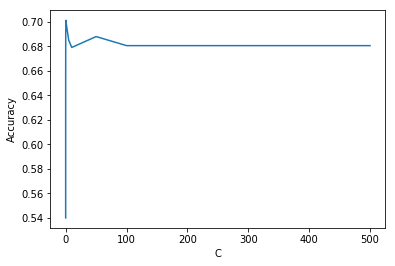

In [127]:
def P6():
    
    #setup regression classifier with the l1 penalty 
    cv_l1 = CountVectorizer()
    traincv_l1= cv_l1.fit_transform(train_data)
    devcv_l1 = cv_l1.transform(dev_data)

    cv_l2 = CountVectorizer()
    traincv_l2= cv_l2.fit_transform(train_data)
    devcv_l2 = cv_l2.transform(dev_data)

    logistic_l1 = LogisticRegression(penalty='l1', tol = 0.01)
    logistic_l1.fit(traincv_l1, train_labels)

    logistic_l2 = LogisticRegression(penalty='l2')
    logistic_l2.fit(traincv_l2, train_labels)

    #loop through logistic.coef_ to pull out values that are above zero 
    words_l1 = []
    words_l2 = []
    for i in range(4):

        c = logistic_l1.coef_[i]
        df = pd.DataFrame(data = c)
        df.columns = ['coef']
        d = df[df.coef > 0].index.tolist()
        words_l1.append(d)

    for i in range(4):

        c = logistic_l2.coef_[i]
        df = pd.DataFrame(data = c)
        df.columns = ['coef']

        d = df[df.coef > 0].index.tolist()
        words_l2.append(d)

    #convert from list of list to one long list
    words_a_l1 = []
    words_a_l2 = []
    for i in words_l1:
        for j in i:
            words_a_l1.append(j)
    for i in words_l2:
        for j in i:
            words_a_l2.append(j)


    #conver to np array and get unique values         
    words_np_l1 = np.array(words_a_l1)
    words_u_l1 = np.unique(words_np_l1)

    words_np_l2 = np.array(words_a_l2)
    words_u_l2 = np.unique(words_np_l2)

    print("Length of L1 non-zero weights: ", len(words_u_l1))
    print("Length of L2 non-zero weights: ", len(words_u_l2))

    #look up words from get_feature_names for each index value 
    words_2 = [cv_l1.get_feature_names()[i] for i in words_u_l1]


    #create new classifier that uses custome vocab list 
    cv2 = CountVectorizer(vocabulary = words_2)
    traincv2= cv2.fit_transform(train_data)
    devcv2 = cv2.transform(dev_data)
    print("Dictionary size of retrained model: ", len(words_2))

    
    #designate possible values for C
    c = [500, 100, 50, 10, 5, 1,0.5,0.1,0.01,0.001,0.0001]
    
    #loop through each C value 
    print("C values and accuracy for the new re-trained model: ")
    accuracy = []
    for i in c:
         #setup new classifier with l2 penalty 
        logistic2 = LogisticRegression(penalty='l2', C = i, tol=0.01)
        logistic2.fit(traincv2, train_labels)
        accuracy.append(logistic2.score(devcv2, dev_labels))

    #setup a dataframe for display
    df = pd.DataFrame(list(zip(c, accuracy)),
              columns=['C','Accuracy'])
    print(df)
    
    #setup the plot 
    plt.plot(c, accuracy)
    plt.ylabel('Accuracy')
    plt.xlabel('C')
    plt.show()
    
 
    ### STUDENT END ###
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [124]:
def P7():
    ### STUDENT START ###

    #setup of tfidf vectorizer
    tf = TfidfVectorizer()
    train_t = tf.fit_transform(train_data)
    dev_t = tf.transform(dev_data)
    
    
    #setup model and fit data 
    logistic = LogisticRegression(C = 100)
    logistic.fit(train_t, train_labels)
    
    #setup predicted labels and probabilities for each
    pred = logistic.predict(dev_t)
    prob = logistic.predict_proba(dev_t)
    
    
    #loop through to determine correct probabilities and the max probabilities to create r-values and get the top 3 ratios
    correct_prob = []
    max_prob = []
    r = []
    for i in range(len(dev_labels)):
        correct_prob.append((prob[i][dev_labels[i]]))
        max_prob.append(max(prob[i]))
  
    for i in range(len(correct_prob)):
        ratio = max_prob[i]/correct_prob[i]
        r.append(ratio)

    df = pd.DataFrame(data = r)
    df.columns = ['R']
    b = df.sort_values(by = 'R', ascending = False)[0:3].index.tolist()
    print(b)
    
    for i in b:
        print("Predicted label: ", pred[i], newsgroups_train.target_names[pred[i]])
        print("Max/predicted probability: ", max_prob[i])
        print("Dev label: ", dev_labels[i], newsgroups_train.target_names[dev_labels[i]])
        print("Correct Probability: ", correct_prob[i])
        print("R value: ", r[i])
        print("Text: \n", dev_data[i])
        print("\n")
#     labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
    

    
    


    ### STUDENT END ###
P7()

[215, 665, 607]
Predicted label:  1 comp.graphics
Max/predicted probability:  0.993720251228
Dev label:  3 talk.religion.misc
Correct Probability:  0.00106925446227
R value:  929.358058619
Text: 
 I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), 

After reviewing the text of the value with the highest R-values, I noticed a couple of errors. The top 2 values are incorrectly misclassifying the text as comp.graphics where in fact it should be talk.religion. I believe this is due to a couple of reasons. First, the word "ftp" is used frequently in these two examples and I would think ftp is highly correlated with the graphics section. Second, even though the word Mormon should be significantly correlated with religion, it is not, this can be due to the fact that the Mormon religion is rather small and does not get enough mentions in the training data set for religion. One way to address this problem is to artificially or manually increate the weights for "ftp" and "Mormon". 

ANSWER:

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance

In [128]:
def P8():
    
    #create list of words to add to weight to
    added_words = ['Mormon']
    train_data_w = deepcopy(train_data)
    
    #loop through training data to add the text of the added weights to those in the "religion" category
    for i in range(len(train_data_w)):
        if train_labels[i] == 3:
            train_data_w[i] = train_data_w[i] + added_words[0]
            
    
    #setup of tfidf vectorizer
    tf = TfidfVectorizer()
    train_t = tf.fit_transform(train_data_w)
    dev_t = tf.transform(dev_data)
    
    
    #setup model and fit data 
    logistic = LogisticRegression(C = 100)
    logistic.fit(train_t, train_labels)
    
    #setup predicted labels and probabilities for each
    pred = logistic.predict(dev_t)
    prob = logistic.predict_proba(dev_t)
    
    
    #loop through to determine correct probabilities and the max probabilities to create r-values and get the top 3 ratios
    correct_prob = []
    max_prob = []
    r = []
    for i in range(len(dev_labels)):
        correct_prob.append((prob[i][dev_labels[i]]))
        max_prob.append(max(prob[i]))
  
    for i in range(len(correct_prob)):
        ratio = max_prob[i]/correct_prob[i]
        r.append(ratio)

    b = [215, 665]
    
    for i in b:
        print("Predicted label: ", pred[i], newsgroups_train.target_names[pred[i]])
        print("Max/predicted probability: ", max_prob[i])
        print("Dev label: ", dev_labels[i], newsgroups_train.target_names[dev_labels[i]])
        print("Correct Probability: ", correct_prob[i])
        print("R value: ", r[i])
        print("Text: \n", dev_data[i])
        print("\n")
#     labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
    
    
    

P8()

Predicted label:  1 comp.graphics
Max/predicted probability:  0.900712466678
Dev label:  3 talk.religion.misc
Correct Probability:  0.0981496637426
R value:  9.17692870594
Text: 
 I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charg

After noticing an underserved weighting for the word "Mormon", I decided to create a list of words (one in this case) to add to each training data that is labeled in the 'religion' category. What this does is it artificially increases the coefficient weighting to the word "Mormon". When rerunning it against the dev data, it immediately recognizes the high weighting of the word "Mormon" and the R value is significantly reduced. Although it still didn't correctly classify the data as "religion", it is still a major improvement in reducing the R values for these two examples. 